# 1. Import Libraries

In [13]:
 
#mandatory libraries
import os
import re
import string
import numpy as np
import pandas as pd

#plotting libraries
import venn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


#NLTK libraries  & for data cleaning
import contractions
import nltk
from nltk.tree import Tree
from nltk.corpus import stopwords
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS

#sk-learn libraries for vectorization and TSNE
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#miscellaneous libraries
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from itertools import combinations 

# 2. Load Dataset

In [14]:
data=pd.read_csv("train.csv")

# 3. Study Dataset
### 3.1 Shape of Dataset

Check shape of dataset

In [15]:

data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


### 3.2 Checking the Missing Values in Data-set

In [16]:
data.isnull().values.any() 
data.duplicated().values.any()

False

No missing values in any of the columns

### 3.3 Checking the Duplicate Values in Data-set

In [17]:
data.duplicated().values.any()

False

### 3.4 Basic Statistics

In [18]:
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From the above output, once again it is clear that no values are missing in any of the columns.

Since id and comment_text are text features, no mean, std, 25th, 50th,75th percentiles are caluculated.

Since, only target labels are numeric in our dataset, describe function calculated basic statistics on targets.

### 3.5 Value-Counts on Target Labels Individually


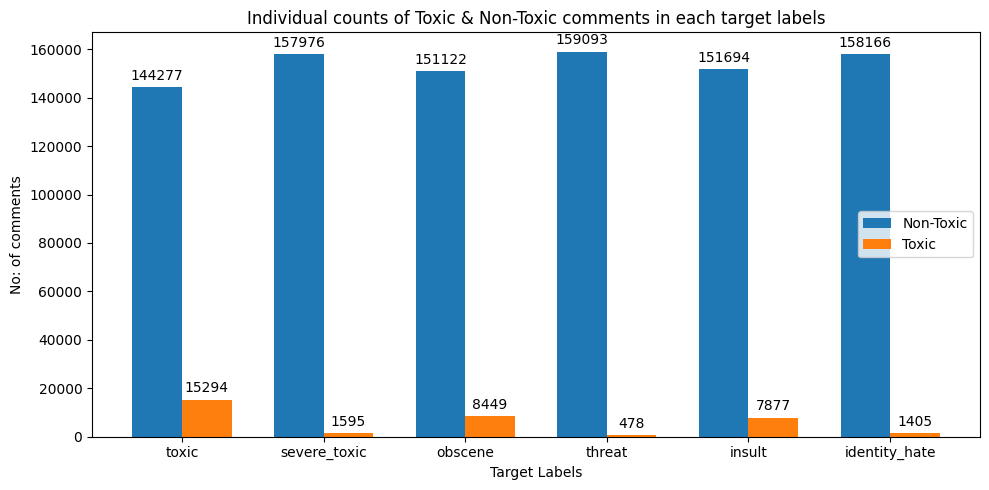

In [19]:
labels = data.columns.values[2:]
class_0=[]
class_1=[]

for i in data.columns.values[2:]:
    vc=data[i].value_counts()
    class_0.append(vc[0])
    class_1.append(vc[1])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, class_0, width, label='Non-Toxic')
rects2 = ax.bar(x + width/2, class_1, width, label='Toxic')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No: of comments')
ax.set_xlabel("Target Labels")
ax.set_title('Individual counts of Toxic & Non-Toxic comments in each target labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=7)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.bar
fig.tight_layout()

plt.show()

The plot above is the individual counts of class zero & class 1, ie comment is classified as toxic= class 1 and comment is classified as non-toxic= class 0.

From this plot we can understand that the data set is highly imbalanced.

This is pictorial representation of value counts of classes, for each target individually

### 3.6 Corelation between target variables

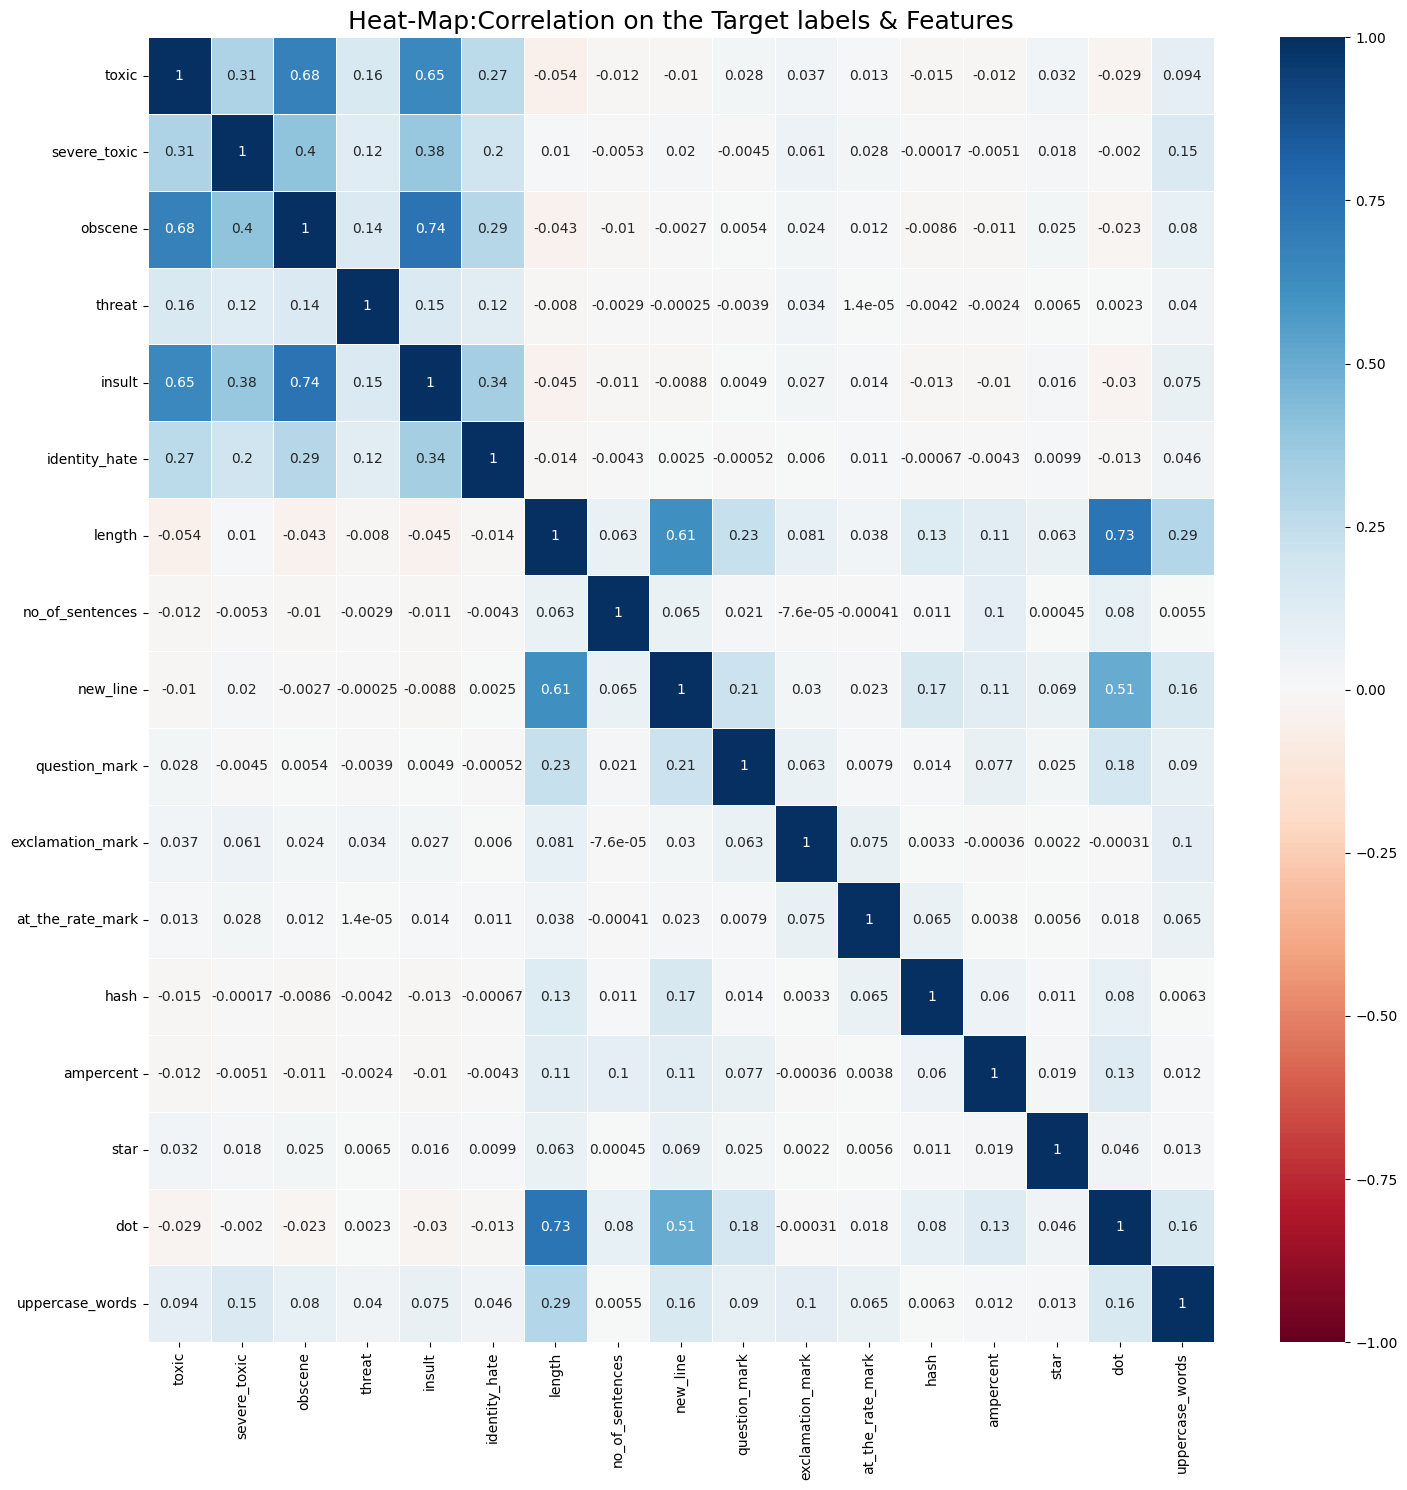

In [20]:
corr_df=data.drop(columns=["id","comment_text"])
corr_df['length']=data['comment_text'].str.len()
corr_df['no_of_sentences']=data['comment_text'].str.split("/n").apply(len)
corr_df['new_line'] = data['comment_text'].str.count('\n')
corr_df['question_mark'] = data['comment_text'].str.count('\?')
corr_df['exclamation_mark'] = data['comment_text'].str.count('!')
corr_df['at_the_rate_mark'] = data['comment_text'].str.count('@')
corr_df['hash'] = data['comment_text'].str.count('#')
corr_df['ampercent'] = data['comment_text'].str.count('&')
corr_df['star']= data['comment_text'].str.count('\*')
corr_df['dot'] = data['comment_text'].str.count('\.')
corr_df['uppercase_words'] = data['comment_text'].str.split().apply(lambda x: sum(map(str.isupper, x)))

correlation=corr_df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(correlation,vmin=-1,cmap='RdBu',annot=True,linewidths=.5)
plt.title("Heat-Map:Correlation on the Target labels & Features",fontsize=18)
plt.tight_layout()

The correlation plot show that there is good relation between the labels toxic and insult, toxic and obscene, and obscene and insult. So, in the presence of one of the labels in the pairs for a comment, it is likely that the comment will also have the other label.


# 5. Preprocessing

Pre-process the data, before feeding to the model. Since our input is text/string type, let's investigate and retain only useful information in the input text.

In [21]:

indices=np.random.randint(data.shape[0],size=5)

for i in indices:
    print(i,"--->",data['comment_text'].values[i])

71712 ---> Thanks 

Thanks for your support during my time here, unfortunately it seems Tony is very well placed.  Undoubtedly due to my support for his RfAr, I am no falsely accused of sockpuppetry.  Radient was good enough to unblock me, but given the users participating it is clear Tony and his ilk run Wikipedia.  Quite frankly, this sort of abuse of the system and blatent mob style tactics is the last straw.  I am leaving for good here.  My only purpose in coming back was to fight this sort of thing, but given those involved, it's a battle that cannot be won.  Goodbye and goodluck.
37932 ---> editing my talk page 

Listen!, GSK I am sick of finding you're frickin, lame advice on my talk page. KEEP YOUR NOSE IN YOUR OWN BUSINESS! From now no more speedy deletion, warnings, or blockage of editing!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! NOW SHUT UP, YOU MORON!!!
124123 ---> H

From above random samples, we can understand there are so many line breaks ("\n") and punctation marks,and some upper cased words,stop words,Decontractions, HTML tags, links etc. So lets clean all those unncessary wor

### 5.1 Preprocessing Functions


In [22]:
def convert_to_lower_case(text):

    """function to convert the input text to lower case"""
    
    return text.lower()
def remove_escape_char(text):

    """function to remove newline (\n),
    tab(\t) and slashes (/ , \) from the input text"""

    return re.sub(r"[\n\t\\\/]"," ",text, flags=re.MULTILINE)
def remove_html_tags(text):

    """function to remove html tags (< >) and its content 
    from the input text"""

    return re.sub(r"<.*>"," ",text, flags=re.MULTILINE)
def remove_links(text):
    """function to remove any kind of links with no 
    html tags"""

    text= re.sub(r"http\S+"," ",text, flags=re.MULTILINE)

    return re.sub(r"www\S+"," ",text, flags=re.MULTILINE)
def remove_digits(text):

    """function to remove digits from the input text"""

    return re.sub(r'\d'," ",text, flags=re.MULTILINE)
def remove_punctuation(text):

    """function to remove punctuation marks from the input text"""

    for i in string.punctuation:
        text = text.replace(i," ")

    return text      
def chuncking(text):

    """function to perform chucking, which is also referred as shallow parsing.
    This is useful in determing the parts of speech of a given text and adds more
    structure to the input data ."""

    """In this function, we use NLTK library to perform chuncking and if a 
    particular label is PERSON names, we remove that, and names of Geo-graphic
    
    ares are retained by adding _ in its words.ex-New_York"""


    chunks_data=[]
    chunks_data=(list(ne_chunk(pos_tag(word_tokenize(text)))))
    for label in chunks_data:
        if type(label)==Tree:
            if label.label() == "GPE":
                a = label.leaves()
                if len(a)>1:
                    gpe = "_".join([term for term,pos in a])
                    text = re.sub(rf'{a[1][0]}',gpe,text, flags=re.MULTILINE)
                    text = re.sub(rf'\b{a[0][0]}\b'," ",text, flags=re.MULTILINE)
            if label.label()=="PERSON":      
                for term,pog in label.leaves():
                    text = re.sub(re.escape(term)," ",text, flags=re.MULTILINE)
    return text
def keep_alpha_and_underscore(text):

    """function to keep only aphabets and _ underscore, as we 
    added it in the chunking for geographic locations."""
    
    return re.sub(r"[^a-zA-Z_]"," ",text,flags=re.MULTILINE)
def remove_extra_spaces_if_any(text):

    """function to remove extra spaces if any after all the pre-preocessing"""
    
    return re.sub(r" {2,}", " ", text, flags=re.MULTILINE)
#on close observation of toxic comments, In some of the bad comments, words in 
#bad words characters are repeated. say for example...
#the word "shit" is written as SSSSHHHHHHHHIIIIIIIIIIITTTTTT
#but the base word is "shit", in order to increase model performance
# i am adding this.

def remove_repeated_characters(text):

    """function to remove repeated characters if any from the input text"""

    """for example CAAAAASSSSSSEEEEE SSSSTTTTTUUUUUUDDDDYYYYYY gives CASE STUDY"""

    return re.sub(r"(\w)(\1{2,})","\\1",text,flags=re.MULTILINE)
#sample check
remove_repeated_characters("CAAAAASSSSSSEEEEE SSSSTTTTTUUUUUUDDDDYYYYYY")
'CASE STUDY'
def remove_words_lesth2(text):
    """function to remove words with length less than 2"""

    text = re.sub(r'\b\w{1,2}\b'," ",text)
    
    return text
def decontraction(text):

    """function to handle contraction errors"""
    res=""
    for word in text.split():
        try:
            con_text=contractions.fix(word)
            if con_text.lower() is word.lower():
                res=res+word+" "
            else:
                res=res+con_text+" "
        
        except:
            con_text=contractions.fix(word.lower())
            if con_text.lower() is word.lower():
                res=res+word+" "
            else:
                res=res+con_text+" "
    return res.strip()

### 5.2 Stop-Words

Stop words means, which doesn't carry any importance in classification task. ie., words which are most occuring in the data-set and doesnt carry any importance in classifying either a positive/negative class. words like the, i , he, she, we, our, his, her, it, a , an, in, of, one, two, three, four, etc

In [23]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [Errno 54] Connection
[nltk_data]     reset by peer>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 54] Connection reset by peer>
[nltk_data] Error loading maxent_ne_chunker: <urlopen error [Errno 54]
[nltk_data]     Connection reset by peer>
[nltk_data] Downloading package words to
[nltk_data]     /Users/codeninja2/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/codeninja2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/codeninja2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Stop Words in NLTK

In [24]:
stop_words=stopwords.words('english')
display_length=10

for i in range(int(np.ceil(len(stop_words)/display_length))):
    print(stop_words[i*display_length:(i+1)*display_length])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
["you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']
['himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself']
['they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this']
['that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be']
['been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing']
['a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until']
['while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into']
['through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down']
['in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once']
['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']
['few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only']
['own', 'same', 'so

Stop words in Word Cloud Library

In [25]:
display_length=10
word_cloud_stp_wrds=list(STOPWORDS)
for i in range(int(np.ceil(len(list(word_cloud_stp_wrds))/display_length))):
    print(word_cloud_stp_wrds[i*display_length:(i+1)*display_length])

["when's", 'because', 'have', 'ours', "where's", 'than', 'off', "didn't", "doesn't", 'would']
['and', 'should', 'him', 'being', 'nor', 'then', 'not', 'since', 'here', 'does']
['when', 'all', 'www', 'until', 'which', 'otherwise', 'how', 'below', 'some', "he's"]
["we've", 'of', 'no', 'same', 'such', 'there', "how's", "they'd", "why's", 'yourself']
['any', 'also', 'once', "she'd", 'a', 'like', 'or', "there's", 'could', 'who']
["you'd", 'down', 'therefore', 'else', "wouldn't", 'this', 'our', "couldn't", 'yours', 'above']
['other', 'was', 'where', 'if', "we'd", "won't", "here's", 'myself', "they're", 'ought']
["wasn't", "you're", 'he', 'its', 'only', 'did', 'http', 'your', 'why', 'be']
["hadn't", "she's", "i'm", 'over', 'in', 'hers', 'r', 'up', "you've", 'most']
["he'll", "can't", 'through', 'had', 'but', "shouldn't", "i'd", 'out', 'shall', 'cannot']
['after', 'however', 'ever', 'more', 'just', "shan't", 'com', 'from', 'ourselves', 'so']
['are', 'too', 'against', 'while', 'both', "you'll", 

Combine all the stop words from both NLTK & Word Cloud libraries, along with some custom words

In [26]:
final_stop_words=list(STOPWORDS.union(set(stop_words)))
final_stop_words.extend(["mr","mrs","miss",
                        "one","two","three","four","five",
                        "six","seven","eight","nine","ten",
                        "us","also","dont","cant","any","can","along",
                        "among","during","anyone",
                         "a","b","c","d","e","f","g","h","i","j","k","l","m",
                         "n","o","p","q","r","s","t","u","v","w","x","y","z","hi","hello","hey","ok",
                         "okay","lol","rofl","hola","let","may","etc"])

display_length=10

for i in range(int(np.ceil(len(final_stop_words)/display_length))):
    print(final_stop_words[i*display_length:(i+1)*display_length])

['because', 'have', "needn't", 'than', "didn't", "doesn't", 'would', 'and', 'should', 'him']
['nor', 'when', 'here', 'does', 'all', 'www', 'until', 'which', 'otherwise', 'below']
["we've", 'same', 'hadn', "they'd", "should've", "why's", 'wouldn', 'also', "there's", 'who']
['or', 's', "you'd", 'down', 've', 'above', 'other', 'if', "we'd", "won't"]
['ain', 'm', 'myself', "they're", 'ought', "that'll", 'he', 'needn', 'its', 'll']
['weren', "i'm", 'over', 'up', "can't", 'had', 'but', "i'd", 'however', 'after']
['ever', 'y', 'com', 'ourselves', 'too', 'against', 'while', 'both', "you'll", 'few']
['between', 'before', 'you', 'they', 'i', 'itself', "what's", "she'll", 'am', 'hence']
["mightn't", 'do', 'is', 'their', 'further', 'himself', 'won', 'we', 'with', 'about']
['has', "who's", "they've", 'an', 'get', "let's", 'as', 'didn', "i'll", 'very']
['each', 'ma', "isn't", 'having', "don't", "they'll", 'my', 'now', 'them', 'his']
['into', "here's", 'herself', "when's", 'ours', "where's", 'off', '

### 5.3 Lemmatization 

Lemmatization is the process of grouping different forms of words in to a single word. Lemmatization and stemming are similar. But Lemmatization brings the meaning to the context and morphological analysis.

For Example

Good--> Better--> Best all are based on the word "Good"

Dogs--> Dog

Apples--> Apple

In [27]:
lemmatiser = WordNetLemmatizer()

Defining the one-step preprocessing function to perform all the different pre-processing steps noted above.

In [28]:
def preprocess(text):

    preprocessed_text = []

    for each_text in tqdm(text):

        result=remove_links(each_text)
        result=remove_html_tags(result)
        result=remove_escape_char(result)        
        result=remove_digits(result)
        result=decontraction(result)
        result=remove_punctuation(result)
        result=chuncking(result)
        result=convert_to_lower_case(result)
        result = ' '.join(non_stop_word for non_stop_word in result.split() if non_stop_word not in final_stop_words)
        result=keep_alpha_and_underscore(result)
        result=remove_extra_spaces_if_any(result)
        result=remove_repeated_characters(result)
        result=remove_words_lesth2(result)
        result=' '.join(lemmatiser.lemmatize(word,pos="v") for word in result.split())
        preprocessed_text.append(result.strip())
        
    return preprocessed_text

In [29]:
from ipywidgets import FloatProgress
indices=np.random.randint(len(data['comment_text'].values),size=5)
indices= np.append(indices,999)

for i in indices:
    print(i," - Original Text ---> ",data['comment_text'].values[i])
    print(i," - Processed Text ---> ",preprocess([data['comment_text'].values[i]]))

126675  - Original Text --->  "

 Reliable source for party ideology: social liberalism 

You can use the 2012 party platform as a reliable source to establish the party's ideology. For example, page 6 establishes that the party ""comprises itself with closing inequality gaps""—that would qualify the party as liberal. I'm not interested in these matters so somebody else can deal with this kind of things. —  "


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


126675  - Processed Text --->  ['reliable source party ideology social liberalism use party platform reliable source establish party ideology example page establish party comprise close inequality gap that qualify party liberal interest matter somebody deal kind things']
41136  - Original Text --->  I saw your reply 

Well i am 16 also, and i spend most of my time studing and doing homework and am not gay by doing corrections on wikipedia. My final word is to stop ok just stop and go out side to play because you probaly weigh 400 pounds. Lose some weight. LOSE SOME WEIGHT, FATTY!!!!!!!!!!!

IF THERE IS SOMETHING YOU ARE GOING TO TAKE OUT OF THIS DISCUSSION, IS THAT TO LOSS THOSE MAN BOOBS AND BELLY.


100%|██████████| 1/1 [00:00<00:00, 65.68it/s]


41136  - Processed Text --->  ['saw reply well spend time stud homework gay corrections wikipedia final word stop stop side play probaly weigh pound lose weight lose weight fatty something go take discussion loss man boob belly']
27803  - Original Text --->  Andrew please note this article is about a business run by a Georgia Tech alumni, Leland Strange who has been involved in the company in one way or another sine 1984. The article helps give background on other articles, VisionPlus was created by this compnay prior to them selling the rest of the business to First Data, First Data this compnay was spun out of First Data , TYSYS lists this compnay as a competitor, and one on prepaid cards the compnay makes products to support that market. There is no mention of any of the company’s current products or discussion of their current sales efforts. The artilce is very similiar to the articles on First Data and TYSYS. If you are nomintaing this for deletion then I suggest you do the same f

100%|██████████| 1/1 [00:00<00:00, 32.48it/s]


27803  - Processed Text --->  ['andrew please note article business run georgia tech alumni involve company way another sine article help give background article visionplus create compnay prior sell rest business compnay spin tysys list compnay competitor prepay card compnay make products support market mention company current products discussion current sales efforts artilce similiar article tysys nomintaing deletion suggest tysys please note review say need link add place credit card helpful delete']
34322  - Original Text --->  Hmmm, am I a reincarnation of Gidonb? Here and here your name is recently mentioned. I think I am fighting now a lost battle, but it tells a lot that after you left the Dutch Wikipedia a couple of years ago, your spirit is still alive!! -) I agree with your analyses above. Although for almost over a year, he didn't change the article: just recently adding his pov, which prompted me to correct it and start a discussion. So my opinion you never know what impact

100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


34322  - Processed Text --->  ['reincarnation gidonb name recently mention think fight lose battle tell lot leave dutch wikipedia couple years ago spirit still alive agree analyse although almost year change article recently add pov prompt correct start discussion opinion never know impact edit positive note think follow footsteps change portal years neglect unfortunately zero feedback personally think improvement almost unchanged start think might appreciate actually something portal start yiddish acticles hoteldebotel koefnoen uitdrukking create work categorie jiddisch add new article plan start portal well jewish topics find hard sjabbatkaarsen isra davis cup jiddisch van tot many others input others whatsoever maybe key difference english wikipedia many people contribute topics hope become active well probabely month orso tuv']
43738  - Original Text --->  "

 GLdF 

As long as we are on the subject... you may want to check out the GLDF article.  I have corrected some of the worst 

100%|██████████| 1/1 [00:00<00:00, 63.58it/s]


43738  - Processed Text --->  ['gldf long subject want check gldf article correct worst mischaractarizations state gldf enjoy privilege status america due amity prince hall gls note list ones even edit still masterpiece puffery course expect corrections stand unchallenged long']
999  - Original Text --->  this title should redirect to Altona, Hamburg. I w'd change it but at the moment there are too many links for me to bother.


100%|██████████| 1/1 [00:00<00:00, 201.20it/s]

999  - Processed Text --->  ['title redirect change moment many link bother']


### 5.4 Perform the pre-processing on all the comments in the data-set

In [30]:
# preprocessed_data = preprocess(data['comment_text'].values)

Create preprocessed data csv

In [31]:

# clean_data=data.drop(columns=["id"])
# clean_data['comment_text']=preprocessed_data
# clean_data.to_csv("pre_processed_data.csv", header=True, index=False)

# 6. Featurization 

In this section, let us convert text features into vectors ie vectorization. In order to avoid data leackage, let's split the whole data set into train and test data sets and then apply the vectorization.

In [32]:
clean_data=pd.read_csv("pre_processed_data.csv")

### 6.1 Clean empty comments

In [33]:
clean_data.isnull().values.any()

True

Check random sample for null comments

In [34]:
index=clean_data[clean_data['comment_text'].isnull()].index
sample=np.random.choice(index,5)

for i in sample:
    print(i,"- index data before pre-processing-->",data['comment_text'].values[i])
    print(i,"- index data after pre-processing-->",clean_data['comment_text'].values[i])
    print("="*100)

128675 - index data before pre-processing--> Worthless Settler Goof Says
128675 - index data after pre-processing--> nan
108567 - index data before pre-processing--> Merry Merry
To you and yours
108567 - index data after pre-processing--> nan
12833 - index data before pre-processing--> Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
Hi Raul!
[http://kapitalism.net/th
12833 - index data after pre-processing

Most of the comments contains purely numbers, stop-words and links. In pre-processing all these unwanted data has been cleaned and no data exists in that comments.that is why we have nan/nulls in the cleaned data

In [35]:
clean_data.dropna(inplace=True)
clean_data.isnull().values.any()

False

In [36]:
# clean_data.to_csv("pre_processed_data_no_nan.csv",header=True, index=False)

In [37]:
# clean_data=pd.read_csv("pre_processed_data_no_nan.csv")

In [38]:
clean_data.shape

(159190, 7)

In [39]:
clean_data.sample(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
91566,blow senor fox news number news channel americ...,1,0,0,0,0,0
125586,recently expand article suggest good hook dyk ...,0,0,0,0,0,0
58370,bhikshu sanskrit term pali write,0,0,0,0,0,0


### 6.2 Split Dataset

In [40]:
X=clean_data['comment_text']
y=clean_data.drop(columns=['comment_text'])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                        random_state=42, shuffle=True)

In [42]:
print("Shape of X-Train",X_train.shape)
print("Shape of X-Test",X_test.shape)
print("Shape of y-Train",y_train.shape)
print("Shape of y-Test",y_test.shape)

Shape of X-Train (111433,)
Shape of X-Test (47757,)
Shape of y-Train (111433, 6)
Shape of y-Test (47757, 6)


In [43]:
def change_y(data):

    """"function to convert multiple y labels as single y label"""
    #this is done to plot T-SNE
    res=[]
    for row in data:
        if (sum(row)==0):
            res.append(0)
        else:
            res.append(1)
    return np.array(res)

In [44]:
y_train_tsne=change_y(y_train.values)
y_test_tsne=change_y(y_test.values)
#converting multi y label to single y label
print("Shape of y-Train",y_train_tsne.shape)
print("Shape of y-Test",y_test_tsne.shape)

Shape of y-Train (111433,)
Shape of y-Test (47757,)


# 6.2 Vectorization using TF-IDF

Convert text features into numerical representation. We have various featurizing techniques/algorthms to acheive the same. Here we are using TF-IDF.


#### Bigrams

In [45]:
#Vectorizing essay feature (text) with TF-IDF

vectorizer = TfidfVectorizer(min_df=10,max_features=10000,ngram_range=(2,2),stop_words=final_stop_words)

vectorizer.fit(X_train.values)

# test datacorpus need to be transformed using train vocabulary
X_train_tfidf_bi = vectorizer.transform(X_train.values)

X_test_tfidf_bi = vectorizer.transform(X_test.values)

In [46]:
#finding the top TF-IDF values/words per class with bi-grams data.

top_tf_idf_val=[]
for col in tqdm(y_train.columns):
    index=y_train[y_train[col]==1].index
    filtered_data=X_train.loc[index]
    vec_data=vectorizer.transform(filtered_data)
    vec_data=vec_data.A

    #finding the indices of top TF-IDF values across the output

    indices=np.dstack(np.unravel_index(np.argsort(vec_data.ravel()), vec_data.shape))[0][::-1]
    feat=vectorizer.get_feature_names_out()
    avg_tf_idf_scores=dict()

    
    for index in indices:
        if feat[index[1]] in avg_tf_idf_scores:
            value=avg_tf_idf_scores[feat[index[1]]]
            value.append(vec_data[index[0]][index[1]])
            avg_tf_idf_scores[feat[index[1]]]=value
        else:
            avg_tf_idf_scores[feat[index[1]]]=[vec_data[index[0]][index[1]]]

    # TF-IDF value is not same for the same word. as it is depends on 
    #TF value and IDF value
    #TF value will change based on the input. so finding average TF-IDF value

    for key in avg_tf_idf_scores:

        value=np.array(avg_tf_idf_scores[key])
        avg_tf_idf_scores[key]= np.mean(value)

    avg_tf_idf_scores={k: v for k, v in sorted(avg_tf_idf_scores.items(),
                                    key=lambda item: item[1],reverse=True)}

    top_tf_idf_val.append((list(avg_tf_idf_scores.keys()),list(avg_tf_idf_scores.values())))

100%|██████████| 6/6 [11:15<00:00, 112.55s/it]


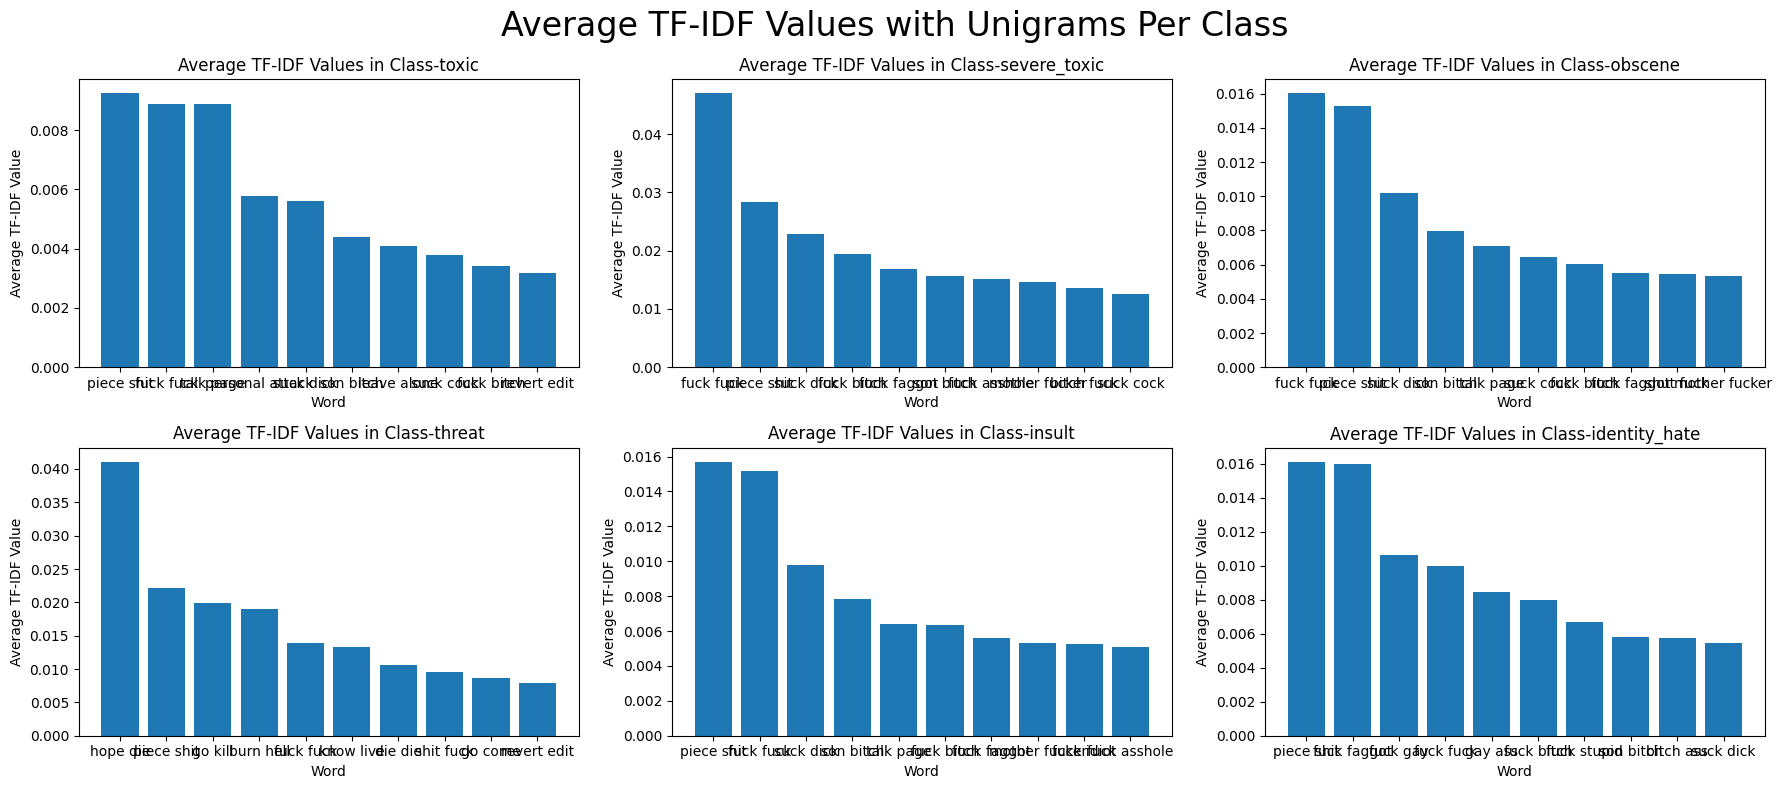

In [47]:
#Plotting the average TF-IDF Value with Uni-gram Per class
fig, axs = plt.subplots(2,3,figsize=(18,8))
fig.suptitle("Average TF-IDF Values with Unigrams Per Class",fontsize=24)
axs=axs.flatten()
for data,ax,col in zip(top_tf_idf_val,axs,y_train.columns):
    words=data[0][:10]
    avg_tf_idf_value=data[1][:10]    
    rects1 = ax.bar(words, avg_tf_idf_value)
    ax.set_ylabel('Average TF-IDF Value')
    ax.set_xlabel("Word")
    ax.set_title('Average TF-IDF Values in Class-'+str(col))
fig.tight_layout()
plt.show()

The above figure is the average TF-IDF values on uni-gram data.

TypeError: PCA initialization is currently not supported with the sparse input matrix. Use init="random" instead.

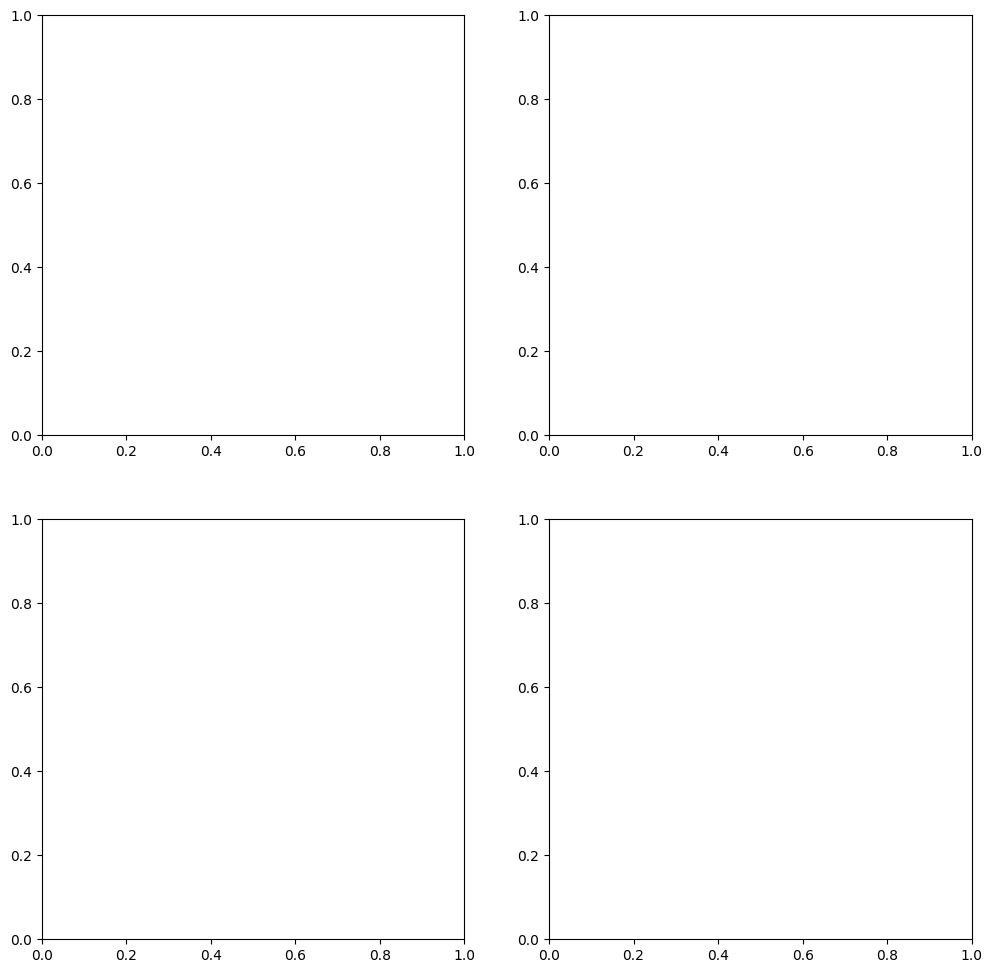

In [49]:
perplexity_list=[10,30,50,100]

fig,axs=plt.subplots(2,2,figsize=(12,12))

axs=axs.flatten()
for per,ax in zip(perplexity_list,axs):

    model = TSNE(n_components=2, random_state=0, perplexity=per,n_jobs=-1, init='random')
    tsne_data = model.fit_transform(X_train_tfidf_bi) 

    # creating a new data fram which help us in ploting the result data
    tsne_data = np.vstack((tsne_data.T, y_train_tsne)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    ax.set_title("TSNE on bi-gram data with perplexity = "+str(per))
    sns.scatterplot(x="Dim_1", y="Dim_2",hue="label",
    data=tsne_df,legend="full",alpha=0.3,ax=ax)

fig.tight_layout()
plt.show()